# Notebook 1: Introduction to xarray
Waterhackweek 2020 | Steven Pestana (spestana@uw.edu)

**By the end of this notebook you will be able to:**
* Create DataArrays and Datasets
* Index and slice DataArrays and Datasets
* Make plots using xarray Datasets
* Export xarray Datasets as NetCDF or csv files

---

# xarray

The [xarray](https://xarray.pydata.org/) library allows us to read, manipulate, and create **labeled** multi-dimensional arrays and datasets, such as NetCDF files.

In the image below, we can imagine having two "data cubes" (3-dimensional data arrays) of temperature and precipitation values, each of which corresponds to a particular x and y spatial coordinate, and t time step.

<img src="https://xarray.pydata.org/en/stable/_images/dataset-diagram.png" width=700>

Let's import xarray and start to explore its features...

In [1]:
import xarray as xr

# we will also be using numpy and pandas, import both of these
import numpy as np
import pandas as pd

# for plotting, import matplotlib.pyplot
import matplotlib.pyplot as plt
# tell jupyter to display plots "inline" in the notebook
%matplotlib inline

---
# DataArrays
Similar to the `numpy.ndarray` object, the `xarray.DataArray` is a multi-dimensional array, with the addition of labeled dimensions, coordinates, and other metadata. A [DataArray](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.html) contains the following: 
* `values` which store the actual data values in a `numpy.ndarray`
* `dims` are the names for each dimension of the `values` array
* `coords` are arrays of labels for each point
* `attrs` is a [dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) that can contain additional metadata


**Let's create some fake streamflow data for two locations to see how these different parts work together to form a DataArray.**

Our goal here is to have 100 years of streamflow data for 2 stream gauges in a DataArray. (Our data will have a shape of 100 x 2)

I'm going to use a numpy function to generate some random numbers that are [normally distributed](https://numpy.org/devdocs/reference/random/generated/numpy.random.normal.html).

In [2]:
# randomly generated annual peak streamflow data for two locations

# give each stream a different mean and standard deviation peak streamflow (cfs)
means = [1000, 900]
standard_deviations = [75, 30] 

# specify that we want to generate 100 random samples for 2 locations
samples = (100, 2)

# generate the random samples
# the .T at the end of the command transforms the numpy array from shape (100, 2) into (2, 100)
peak_streamflow = np.random.normal(means, standard_deviations, samples)

In [3]:
# look at this ndarray we just made
peak_streamflow

array([[ 982.56727525,  847.19860975],
       [1084.15555987,  934.10057162],
       [1135.4312143 ,  883.78613889],
       [ 925.81957695,  822.12312233],
       [1086.80576581,  893.16597316],
       [1106.14034025,  912.80697713],
       [1015.08073992,  953.32426488],
       [1053.74996029,  893.51931265],
       [ 911.03563195,  905.24528699],
       [ 961.37466325,  884.77293174],
       [1004.5847378 ,  820.21756749],
       [1064.314696  ,  900.24642871],
       [1039.7993384 ,  823.02299197],
       [ 989.02486812,  928.83920785],
       [1037.26138111,  902.22770655],
       [1069.77511116,  890.79177912],
       [1004.88036583,  901.74043841],
       [1024.50336995,  860.68356349],
       [ 996.17788285,  877.43102062],
       [1039.13070904,  893.29208003],
       [ 874.57217219,  911.25359028],
       [ 915.85255318,  933.59330321],
       [1028.82671319,  886.31975587],
       [ 996.90312061,  877.87022321],
       [ 982.72390846,  869.84679112],
       [1105.83527941,  9

In [4]:
# look at the shape of this ndarray
peak_streamflow.shape

(100, 2)

`peak_streamflow` will be the `values` within the DataArray. It is a two-dimensional array, and we've given it a shape of 100x2. 

The two dimensions will need names (`dims`) and labels (`coords`)

**Make the `coords` that will be our 100 years**

In [5]:
# Make a sequence of 100 years to be our time dimension
years = pd.date_range('1920', periods=100, freq ='1Y')

**Make the `coords` that will be our 2 locations**

In [6]:
# Make the labels for our two locations
locations = ['east_watershed', 'west_watershed']

**Make the `dims` names**

In [7]:
# We can call our two dimensions time, and location corresponding to the dimensions with lengths 100 (years) and 2 (locations) respectively
dimensions = ['time', 'watershed']

**Finally we can create a metadata dictionary which will be included in the DataArray**

In [8]:
metadata = {'units': 'cfs'}

**Now that we have all the individual components of an xarray DataArray, we can create it**

In [9]:
streamflow = xr.DataArray(peak_streamflow, 
                          coords=[years, locations], 
                          dims=dimensions,  
                          name='peak_streamflow', 
                          attrs=metadata)

**Inspect the DataArray we just created**

In [10]:
streamflow

<xarray.DataArray 'peak_streamflow' (time: 100, watershed: 2)>
array([[ 982.56727525,  847.19860975],
       [1084.15555987,  934.10057162],
       [1135.4312143 ,  883.78613889],
       [ 925.81957695,  822.12312233],
       [1086.80576581,  893.16597316],
       [1106.14034025,  912.80697713],
       [1015.08073992,  953.32426488],
       [1053.74996029,  893.51931265],
       [ 911.03563195,  905.24528699],
       [ 961.37466325,  884.77293174],
       [1004.5847378 ,  820.21756749],
       [1064.314696  ,  900.24642871],
       [1039.7993384 ,  823.02299197],
       [ 989.02486812,  928.83920785],
       [1037.26138111,  902.22770655],
       [1069.77511116,  890.79177912],
       [1004.88036583,  901.74043841],
       [1024.50336995,  860.68356349],
       [ 996.17788285,  877.43102062],
       [1039.13070904,  893.29208003],
...
       [ 890.67994329,  949.67876834],
       [ 933.7999708 ,  937.59795254],
       [ 967.65171805,  951.60778201],
       [1007.22077842,  915.48541333],
       [ 999.97360602,  907.86181505],
       [ 956.86569247,  933.52191256],
       [1083.82474281,  861.84711639],
       [ 858.13989862,  895.24135386],
       [ 832.69139637,  857.39259436],
       [1016.98590241,  926.68774977],
       [ 931.50812768,  925.55012045],
       [ 878.31387961,  882.99930849],
       [1098.16806507,  911.07874413],
       [ 997.47672221,  884.56862181],
       [1005.40181045,  927.79484124],
       [ 955.83414669,  862.37602684],
       [1004.67650854,  904.51859607],
       [1153.85764205,  895.27996253],
       [ 961.18972512,  868.44537126],
       [1003.88785341,  887.03259683]])
Coordinates:
  * time       (time) datetime64[ns] 1920-12-31 1921-12-31 ... 2019-12-31
  * watershed  (watershed) <U14 'east_watershed' 'west_watershed'
Attributes:
    units:    cfs

In [11]:
# Get the DataArray dimensions (labels for coordinates)
streamflow.dims

('time', 'watershed')

In [12]:
# Get the DataArray coordinates
streamflow.coords

Coordinates:
  * time       (time) datetime64[ns] 1920-12-31 1921-12-31 ... 2019-12-31
  * watershed  (watershed) <U14 'east_watershed' 'west_watershed'

In [13]:
# Look at our attributes
streamflow.attrs

{'units': 'cfs'}

In [14]:
# Take a look at the data values
streamflow.values

array([[ 982.56727525,  847.19860975],
       [1084.15555987,  934.10057162],
       [1135.4312143 ,  883.78613889],
       [ 925.81957695,  822.12312233],
       [1086.80576581,  893.16597316],
       [1106.14034025,  912.80697713],
       [1015.08073992,  953.32426488],
       [1053.74996029,  893.51931265],
       [ 911.03563195,  905.24528699],
       [ 961.37466325,  884.77293174],
       [1004.5847378 ,  820.21756749],
       [1064.314696  ,  900.24642871],
       [1039.7993384 ,  823.02299197],
       [ 989.02486812,  928.83920785],
       [1037.26138111,  902.22770655],
       [1069.77511116,  890.79177912],
       [1004.88036583,  901.74043841],
       [1024.50336995,  860.68356349],
       [ 996.17788285,  877.43102062],
       [1039.13070904,  893.29208003],
       [ 874.57217219,  911.25359028],
       [ 915.85255318,  933.59330321],
       [1028.82671319,  886.31975587],
       [ 996.90312061,  877.87022321],
       [ 982.72390846,  869.84679112],
       [1105.83527941,  9

## DataArray indexing/slicing methods

DataArrays can be [indexed or sliced](https://xarray.pydata.org/en/stable/indexing.html) much like ndarrays, but  with the addition of using labels.

| Dimension lookup | Index lookup | DataArray syntax |
| ---              | ---          | ---              |
| positional       | by integer   | `da[:,0]`        |
| positional       | by label     | `da.loc[:,'east_watershed']` |
| by name          | by integer   | `da.isel(watershed=0)` |
| by name          | by label     | `da.sel(watershed='east_watershed')` |

Let's select by name and by label, streamflow for just one watershed, and plot it. (Conveniently, x-array will add axes labels and a title by default.)

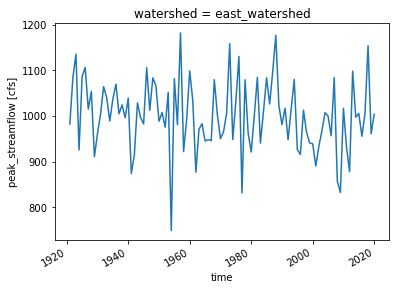

In [15]:
streamflow.sel(watershed='east_watershed').plot()

Now let's select a shorter time range to plot data from both watersheds.

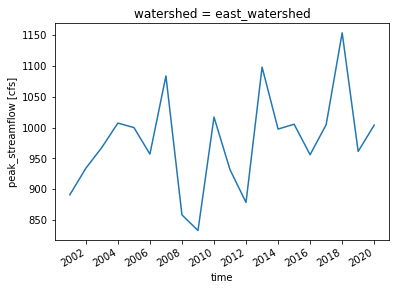

In [16]:
streamflow.sel(watershed='east_watershed', time=slice('2000','2020')).plot()

In [17]:
# Bonus, explore other methods for indexing

# picking the 0th location (positional, by integer)
#streamflow[:,0].plot()

# using .loc() and the name of the location (positional, by label)
#streamflow.loc[:,'east_watershed'].plot()

# (by name, by integer)
#streamflow.isel(watershed=0).plot()

# (by name, by label)
#streamflow.sel(watershed='east_watershed').plot()

---
# Datasets

Similar to the `pandas.dataframe`, the `xarray.Dataset` contains one or more labeled `xarray.DataArray` objects.

We can create a [Dataset](https://xarray.pydata.org/en/stable/data-structures.html#dataset) with our simulated data here. 

**First, create another DataArray with annual cumulative precipitation**

In [18]:
# randomly generated annual cumulative precipitation data for three locations

# give each location a different mean and standard deviation precipitation value (inches)
means = [15, 6]
standard_deviations = [3, 6] 

# specify that we want to generate 100 random samples for 2 locations
samples = (100, 2)

# generate the random samples
cumulative_precip = np.random.normal(means, standard_deviations, samples)

Make the DataArray (note that we're using the same `coords` and `dims` as our streamflow DataArray)

In [19]:
precip = xr.DataArray(cumulative_precip, 
                      coords=[years, locations], 
                      dims=dimensions, name='cumulative_precip', 
                      attrs={'units':'inches'})

**Now merge our two DataArrays and create a Dataset.**

In [20]:
my_data = xr.merge([streamflow, precip])

In [21]:
# inspect the Dataset
my_data

<xarray.Dataset>
Dimensions:            (time: 100, watershed: 2)
Coordinates:
  * time               (time) datetime64[ns] 1920-12-31 ... 2019-12-31
  * watershed          (watershed) <U14 'east_watershed' 'west_watershed'
Data variables:
    peak_streamflow    (time, watershed) float64 982.6 847.2 ... 1.004e+03 887.0
    cumulative_precip  (time, watershed) float64 17.23 -2.323 ... 16.01 16.7

## Dataset indexing/slicing methods

Datasets can also be [indexed or sliced](https://xarray.pydata.org/en/stable/indexing.html) using the `.isel()` or `.sel()` methods.




| Dimension lookup | Index lookup | Dataset syntax |
| ---              | ---          | ---            |
| positional       | by integer   | *n/a* |
| positional       | by label     | *n/a* |
| by name          | by integer   | `ds.isel(location=0)` |
| by name          | by label     | `ds.sel(location='stream_gage_1')` |

**Select peak streamflow and cumulative precipitation for just one watershed**

In [22]:
# by name, by label
my_data.sel(watershed='west_watershed')

# or by name, by integer
#my_data.isel(watershed=1)

<xarray.Dataset>
Dimensions:            (time: 100)
Coordinates:
  * time               (time) datetime64[ns] 1920-12-31 ... 2019-12-31
    watershed          <U14 'west_watershed'
Data variables:
    peak_streamflow    (time) float64 847.2 934.1 883.8 ... 895.3 868.4 887.0
    cumulative_precip  (time) float64 -2.323 7.422 4.326 ... 3.745 7.422 16.7

---

Plot all our data:

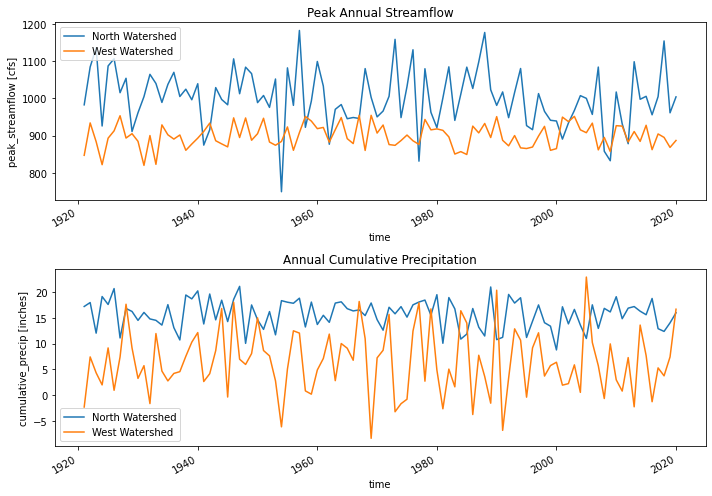

In [23]:
# create a figure with 2 rows and 1 column of subplots
fig, [subplot1, subplot2] = plt.subplots(nrows=2, ncols=1, figsize=(10,7), tight_layout=True)

# first subplot

# Plot stream flow at each of the sites (using the .sel() method here)
my_data.sel(watershed="east_watershed").peak_streamflow.plot(ax=subplot1, label='North Watershed')
my_data.sel(watershed="west_watershed").peak_streamflow.plot(ax=subplot1, label='West Watershed')

# set our legend location
subplot1.legend(loc='upper left')
# set a title for this subplot
subplot1.set_title('Peak Annual Streamflow');

# next subplot

# Plot precipitation at each of the sites (using the .sel() method here)
my_data.sel(watershed="east_watershed").cumulative_precip.plot(ax=subplot2, label='North Watershed')
my_data.sel(watershed="west_watershed").cumulative_precip.plot(ax=subplot2, label='West Watershed')

# set our legend location
subplot2.legend(loc='lower left')
# set a title for this subplot
subplot2.set_title('Annual Cumulative Precipitation');

# save the figure as a jpg image
plt.savefig('my_data_plot.jpg')

**Save our data to a file:**

as a NetCDF file:

In [24]:
my_data.to_netcdf('my_data.nc')

We can also convert a Dataset or DataArray to a pandas dataframe

In [25]:
my_data.to_dataframe()

peak_streamflow  cumulative_precip
time       watershed                                         
1920-12-31 east_watershed       982.567275          17.234804
           west_watershed       847.198610          -2.323257
1921-12-31 east_watershed      1084.155560          17.999279
           west_watershed       934.100572           7.421972
1922-12-31 east_watershed      1135.431214          12.049807
...                                    ...                ...
2017-12-31 west_watershed       895.279963           3.745152
2018-12-31 east_watershed       961.189725          14.051333
           west_watershed       868.445371           7.421667
2019-12-31 east_watershed      1003.887853          16.008587
           west_watershed       887.032597          16.701212

[200 rows x 2 columns]

Via a pandas dataframe, save our data to a csv file

In [26]:
my_data.to_dataframe().to_csv('my_data.csv')